In [1]:
import pandas as pd
import datetime
import numpy as np

# Read and preprocess data
data = pd.read_parquet('hw2_signal.parquet', engine='pyarrow')
msf = pd.read_parquet('crsp.msf.parquet', engine='pyarrow')[['permno', 'hexcd', 'prc', 'shrout', 'date']]
msf['prc'] = msf['prc'].abs()

msf['shrout'] *= msf['prc']
msf = msf.rename(columns = {'permno': 'focal_permno', 'shrout': 'mkt_cap', 'date': 'date_of_return'})
data = data.merge(msf, on = ['focal_permno', 'date_of_return'])

dse = pd.read_parquet('crsp.dsenames.parquet', engine='pyarrow')[['permno', 'shrcd']]
dse = dse.rename(columns = {'permno': 'focal_permno'})

data = data.merge(dse.drop_duplicates(), on = 'focal_permno')

data["date_of_return"] = data["date_of_return"].apply(lambda g: datetime.datetime.strptime(g, "%Y-%m-%d"))
data.index = data["date_of_return"]

print(data.shape)
print(data.head())


(1288586, 10)
                focal_permno date_of_return  ret_tech_peers    closness  \
date_of_return                                                            
2004-03-31             86717     2004-03-31       -0.019743   92.169806   
2001-05-31             86717     2001-05-31       -0.026915   76.996010   
2015-04-30             86717     2015-04-30        0.008317  345.109972   
2018-05-31             86717     2018-05-31        0.032684  230.408746   
2020-06-30             86717     2020-06-30        0.051462  221.601276   

                num_peers  yearmonth  hexcd        prc       mkt_cap  shrcd  
date_of_return                                                               
2004-03-31            284    24052.0    3.0   9.720000  1.648901e+05   11.0  
2001-05-31            226    24018.0    3.0   6.920000  9.023680e+04   11.0  
2015-04-30           1418    24185.0    3.0  26.760000  1.095153e+06   11.0  
2018-05-31           1158    24222.0    3.0  47.560001  1.941732e+06  

In [2]:
# Use quantile function in lecture.
def apply_quantiles(x, include_in_quantiles=None, bins=10):
    # if the argument is specified, we only include some data in the calculate of breakpoints
    if include_in_quantiles is None:
        include_in_quantiles = [True] * len(x)
    # calculate quantiles (breakpoints)
    x = pd.Series(x)
    quantiles = np.quantile(
        x[x.notnull() & include_in_quantiles],
        np.linspace(0, 1, bins+1)
    )
    quantiles[0] = x.dropna().min() - 1
    quantiles[-1] = x.dropna().max() + 1
    # cut the data a bit more
    return pd.cut(x, quantiles, labels=False, duplicates='drop') + 1

# Part 2 (1)(a)

In [3]:
# Create price & market cap lags
lags = 1
data = data.groupby('focal_permno', group_keys=0).apply(lambda g: g.sort_index().drop(['prc', 'mkt_cap'], axis=1).join(g.sort_index()[['prc', 'mkt_cap']].shift(lags).rename(columns={'prc':'prc_lag', 'mkt_cap':'mkt_cap_lag'}))).reset_index(drop=1).dropna()

# hexcd filter
tradeable_data = data[data['hexcd'].isin([1, 2, 3])]
tradeable_data = tradeable_data[tradeable_data['shrcd'].isin([10, 11])]

# Price filter
tradeable_data = tradeable_data[tradeable_data["prc_lag"] > 5]

# market cap filter
tradeable_data = tradeable_data.groupby('date_of_return').apply(lambda g: g[g.mkt_cap_lag > (g['mkt_cap_lag'].max() - g['mkt_cap_lag'].min()) * 0.2 + g['mkt_cap_lag'].min()]).reset_index(drop=1)

In [4]:
# Calculate signal: peer tech return
tradeable_data = tradeable_data.sort_values(["focal_permno","date_of_return"])
tradeable_data.loc[:, 'TECHRET'] = tradeable_data.groupby("focal_permno", group_keys=0).apply(lambda g: g["ret_tech_peers"].shift(lags)).reset_index(drop=1).values
tradeable_data = tradeable_data.dropna()

# Keep focal_permno with >1 data item per day, so that function "apply_quantiles" works.
tradeable_data['num_per_day'] = tradeable_data.groupby(["date_of_return"])['ret_tech_peers'].transform('count')
tradeable_data = tradeable_data[tradeable_data['num_per_day'] > 1]
tradeable_data = tradeable_data.drop('num_per_day', axis=1)

In [5]:
# Rank assets according to signal.
tradeable_data['bin'] = (
    tradeable_data
    .groupby('date_of_return')
    .apply(lambda g: apply_quantiles(g['TECHRET'], bins=10))
    .reset_index([0], drop=True)
    .sort_index()
)

# Create 2 portfolios: equally weighted & value weighted 
portfolios = (
    tradeable_data[
        tradeable_data['bin'].notnull() &
        tradeable_data['ret_tech_peers'].notnull() &
        tradeable_data['mkt_cap_lag'].notnull()
    ]
    .groupby(['bin', 'date_of_return'])[['ret_tech_peers', 'mkt_cap_lag']]
    .apply(
        lambda g: pd.Series({
            'ew': g['ret_tech_peers'].mean(),
            'vw': (g['ret_tech_peers'] * g['mkt_cap_lag']).sum() / g['mkt_cap_lag'].sum()
        })
    )
    .reset_index()
)

<Axes: xlabel='bin'>

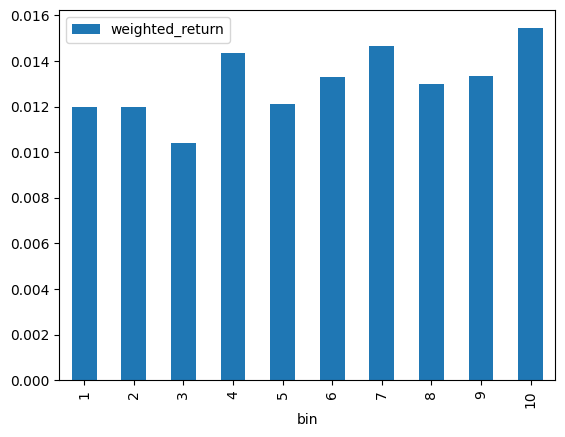

In [6]:
# Weighted return of assets in different bins.
portfolios.groupby('bin').agg(weighted_return=('vw', 'mean')).plot(kind='bar')

<Axes: xlabel='bin'>

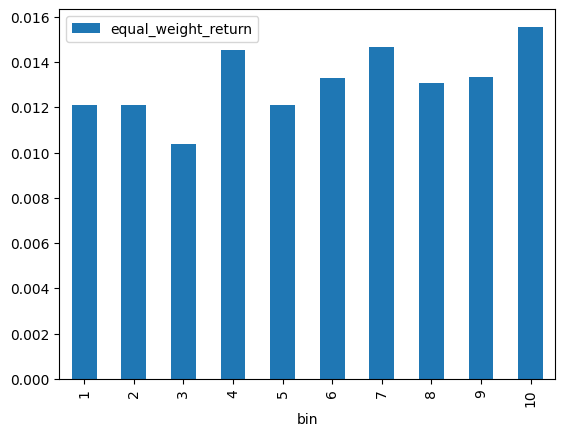

In [7]:
# Weighted return of assets in different bins.
portfolios.groupby('bin').agg(equal_weight_return=('ew', 'mean')).plot(kind='bar')

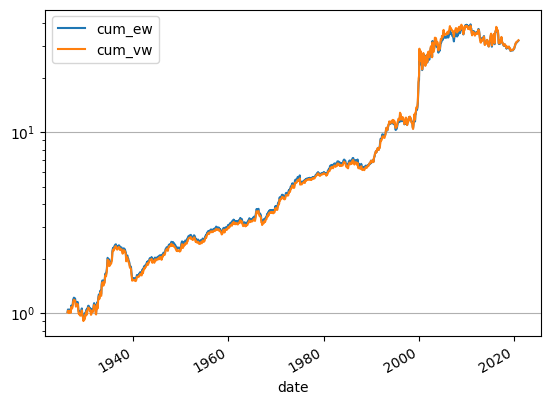

In [8]:
# Long, short bins of portfolio, long bin 10 and short bin 1.
portfolio_LS = pd.merge(
    portfolios.query('bin==10'),
    portfolios.query('bin==1'),
    suffixes=['_long', '_short'],
    on='date_of_return'
)
portfolio_LS['strategy_vw'] = (portfolio_LS['vw_long'] - portfolio_LS['vw_short'])
# plot the pnl curve
portfolio_LS['cum_vw'] = (portfolio_LS['strategy_vw'] + 1).cumprod() - 1 # calculates the cumulative return
# plot both ew and vw
portfolio_LS['strategy_ew'] = (portfolio_LS['ew_long'] - portfolio_LS['ew_short'])
portfolio_LS['cum_ew'] = (portfolio_LS['strategy_ew'] + 1).cumprod() - 1 # calculates the cumulative return

# plot cum_ew and cum_vw against date
(
     portfolio_LS
    .assign(date=pd.to_datetime(portfolio_LS['date_of_return']))
    .assign(cum_vw=portfolio_LS['cum_vw']+1)
    .assign(cum_ew=portfolio_LS['cum_ew']+1)
    .plot(x='date', y=['cum_ew', 'cum_vw'], logy=True).grid(axis='y')
)

In [9]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Regress with 4 factors
benchmark = pd.read_parquet('four_factor_monthly.parquet')
benchmark_merged = pd.merge(
    (
        benchmark
        .assign(date=pd.to_datetime(benchmark['dt']))
        .assign(yearmonth=lambda df: df['date'].dt.year * 12 + df['date'].dt.month)
    ),
    (
        portfolio_LS
        .assign(date=pd.to_datetime(portfolio_LS['date_of_return']))
        .assign(yearmonth=lambda df: df['date'].dt.year * 12 + df['date'].dt.month)
    ),
    on='yearmonth'
)
l1 = smf.ols('cum_vw ~ 1 + smb + hml + mkt_rf + mom', data=benchmark_merged).fit()
l2 = smf.ols('cum_ew ~ 1 + smb + hml + mkt_rf + mom', data=benchmark_merged).fit()
sm.iolib.summary2.summary_col([l1, l2], stars=True)

,cum_vw,cum_ew
Intercept,9.8439***,9.7951***
,(0.3727),(0.3663)
smb,5.9770,5.8123
,(12.4430),(12.2290)
hml,-22.6367**,-22.4210**
,(11.3832),(11.1874)
mkt_rf,-2.8557,-2.5641
,(7.5172),(7.3880)
mom,-15.4092*,-15.4251*
,(8.9187),(8.7654)


In [10]:
# Regress with 5 factors
benchmark = pd.read_parquet('five_factor_monthly.parquet')
benchmark_merged = pd.merge(
    (
        benchmark
        .assign(date=pd.to_datetime(benchmark['dt']))
        .assign(yearmonth=lambda df: df['date'].dt.year * 12 + df['date'].dt.month)
    ),
    (
        portfolio_LS
        .assign(date=pd.to_datetime(portfolio_LS['date_of_return']))
        .assign(yearmonth=lambda df: df['date'].dt.year * 12 + df['date'].dt.month)
    ),
    on='yearmonth'
)

l1 = smf.ols('cum_vw ~ 1 + mkt_rf + smb + hml + rmw + cma', data=benchmark_merged).fit()
l2 = smf.ols('cum_ew ~ 1 + mkt_rf + smb + hml + rmw + cma', data=benchmark_merged).fit()
sm.iolib.summary2.summary_col([l1, l2], stars=True)

,cum_vw,cum_ew
Intercept,15.0719***,14.9521***
,(0.5110),(0.5009)
mkt_rf,3.6187,4.5484
,(12.5937),(12.3457)
smb,8.2171,7.9070
,(17.7652),(17.4154)
hml,-40.5041*,-40.4895*
,(23.7989),(23.3303)
rmw,24.6660,24.1073
,(24.5533),(24.0698)
